In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.7.0+cu118
True
NVIDIA GeForce RTX 3060 Laptop GPU


In [7]:
import os

VOC2007_PATH = r"C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOCtrainval_06-Nov-2007\VOCdevkit\VOC2007"
VOC2012_PATH = r"C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOCtrainval_11-May-2012\VOCdevkit\VOC2012"
YOLO_DATA_PATH = r"C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO"

for split in ['train1', 'val1']:
    os.makedirs(os.path.join(YOLO_DATA_PATH, f'images/{split}'), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DATA_PATH, f'labels/{split}'), exist_ok=True)


In [8]:
import os

def generate_split_file(voc_path, split_name="trainval"):
    annotations_path = os.path.join(voc_path, "Annotations")
    output_dir = os.path.join(voc_path, "ImageSets", "Main")
    os.makedirs(output_dir, exist_ok=True)

    ids = [fname.replace(".xml", "") for fname in os.listdir(annotations_path) if fname.endswith(".xml")]
    ids.sort()

    output_path = os.path.join(output_dir, f"{split_name}.txt")
    with open(output_path, "w") as f:
        for img_id in ids:
            f.write(f"{img_id}\n")

    print(f"✅ {split_name}.txt saved to {output_path}")

generate_split_file(VOC2007_PATH, "trainval")
generate_split_file(VOC2012_PATH, "trainval")


✅ trainval.txt saved to C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOCtrainval_06-Nov-2007\VOCdevkit\VOC2007\ImageSets\Main\trainval.txt
✅ trainval.txt saved to C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOCtrainval_11-May-2012\VOCdevkit\VOC2012\ImageSets\Main\trainval.txt


In [9]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
import shutil

CLASSES = ['aeroplane','bicycle','bird','boat','bottle',
           'bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','pottedplant',
           'sheep','sofa','train1','tvmonitor']

def convert_xml(xml_path, txt_out_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    with open(txt_out_path, 'w') as f:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in CLASSES:
                continue
            cls_id = CLASSES.index(cls)
            xmlbox = obj.find('bndbox')
            xmin = float(xmlbox.find('xmin').text)
            xmax = float(xmlbox.find('xmax').text)
            ymin = float(xmlbox.find('ymin').text)
            ymax = float(xmlbox.find('ymax').text)
            x_center = (xmin + xmax) / 2 / w
            y_center = (ymin + ymax) / 2 / h
            box_w = (xmax - xmin) / w
            box_h = (ymax - ymin) / h
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}\n")

def process_split(voc_path, year, split):
    ids_path = os.path.join(voc_path, 'ImageSets', 'Main', f'{split}.txt')
    with open(ids_path) as f:
        ids = [line.strip() for line in f.readlines()]

    for img_id in tqdm(ids, desc=f"{year} {split}"):
        xml_path = os.path.join(voc_path, 'Annotations', f"{img_id}.xml")
        img_path = os.path.join(voc_path, 'JPEGImages', f"{img_id}.jpg")

        out_img = os.path.join(YOLO_DATA_PATH, f'images/{split}', f"{year}_{img_id}.jpg")
        out_txt = os.path.join(YOLO_DATA_PATH, f'labels/{split}', f"{year}_{img_id}.txt")

        if os.path.exists(xml_path) and os.path.exists(img_path):
            shutil.copy(img_path, out_img)
            convert_xml(xml_path, out_txt)

process_split(VOC2007_PATH, '2007', 'train1')
process_split(VOC2007_PATH, '2007', 'val1')
process_split(VOC2012_PATH, '2012', 'train1')
process_split(VOC2012_PATH, '2012', 'val1')


2012 val: 100%|██████████| 5823/5823 [00:11<00:00, 505.31it/s]


In [11]:
yaml_path = YOLO_DATA_PATH.replace('\\', '/')

yaml_text = f"""
path: {yaml_path}
train1: images/train1
val1: images/val1

nc: 20
names: ['aeroplane','bicycle','bird','boat','bottle',
        'bus','car','cat','chair','cow','diningtable',
        'dog','horse','motorbike','person','pottedplant',
        'sheep','sofa','train1','tvmonitor']
"""

with open(os.path.join(YOLO_DATA_PATH, "voc.yaml"), "w") as f:
    f.write(yaml_text)

print("✅ voc.yaml created.")


✅ voc.yaml created.


In [13]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data=os.path.join(YOLO_DATA_PATH, "voc.yaml"),
    epochs=50,
    imgsz=640,
    batch=16,
    device=0
)


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\lilit\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:01<00:00, 4.99MB/s]


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

100%|██████████| 755k/755k [00:01<00:00, 539kB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    755212  ultralytics.nn.modules.head.Detect           [20, 

100%|██████████| 5.35M/5.35M [00:01<00:00, 5.27MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 228.7125.4 MB/s, size: 105.9 KB)


train: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\train... 8218 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8218/8218 [00:03<00:00, 2062.32it/s]


train: New cache created: C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\train.cache
val: Fast image access  (ping: 0.20.0 ms, read: 130.828.3 MB/s, size: 111.8 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:08<00:00, 995.69it/s] 


val: New cache created: C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.15G       1.03      2.582      1.282         87        640: 100%|██████████| 514/514 [04:12<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [02:13<00:00,  1.96it/s]


                   all       8333      23605      0.695      0.599      0.653      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.73G      1.082      1.829      1.322         66        640: 100%|██████████| 514/514 [03:43<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:53<00:00,  4.90it/s]


                   all       8333      23605       0.67      0.565      0.615      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.75G       1.11      1.793      1.347         47        640: 100%|██████████| 514/514 [01:16<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:43<00:00,  6.00it/s]


                   all       8333      23605       0.63      0.539      0.566      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.75G      1.108       1.73      1.346         45        640: 100%|██████████| 514/514 [01:23<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:42<00:00,  6.17it/s]


                   all       8333      23605      0.647      0.559      0.595      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.78G      1.102      1.632      1.336         47        640: 100%|██████████| 514/514 [01:24<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:42<00:00,  6.11it/s]


                   all       8333      23605      0.669      0.554      0.606      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.79G      1.092      1.579      1.329         59        640: 100%|██████████| 514/514 [01:25<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:45<00:00,  5.78it/s]


                   all       8333      23605      0.679       0.56      0.611      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.81G      1.075      1.515      1.321         85        640: 100%|██████████| 514/514 [01:25<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.83it/s]


                   all       8333      23605      0.691      0.579      0.639      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.82G      1.067      1.464      1.309         53        640: 100%|██████████| 514/514 [01:25<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.90it/s]


                   all       8333      23605      0.699      0.572      0.636       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.84G      1.053      1.425      1.304         63        640: 100%|██████████| 514/514 [01:25<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.92it/s]


                   all       8333      23605      0.715      0.593       0.66       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.86G      1.047      1.388      1.296         61        640: 100%|██████████| 514/514 [01:25<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.91it/s]


                   all       8333      23605      0.732      0.595      0.664      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.87G      1.043       1.37      1.292         69        640: 100%|██████████| 514/514 [01:25<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.91it/s]


                   all       8333      23605      0.728      0.598      0.663      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.88G      1.028      1.338      1.283         45        640: 100%|██████████| 514/514 [01:25<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.84it/s]


                   all       8333      23605      0.738      0.597      0.671      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.05G      1.019        1.3      1.274         78        640: 100%|██████████| 514/514 [01:28<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.84it/s]


                   all       8333      23605      0.723      0.598      0.667      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.24G      1.011      1.287      1.271         80        640: 100%|██████████| 514/514 [01:25<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.91it/s]


                   all       8333      23605      0.733      0.616      0.682      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.73G      1.008      1.267      1.266         88        640: 100%|██████████| 514/514 [01:45<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [01:16<00:00,  3.42it/s]


                   all       8333      23605       0.74      0.612      0.685      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.73G     0.9977      1.242       1.26         59        640: 100%|██████████| 514/514 [01:48<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


                   all       8333      23605      0.755      0.615      0.695      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.73G     0.9926      1.222      1.256         66        640: 100%|██████████| 514/514 [01:34<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [01:08<00:00,  3.81it/s]


                   all       8333      23605       0.75       0.62      0.693      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.73G     0.9811      1.211      1.255         62        640: 100%|██████████| 514/514 [01:48<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [01:08<00:00,  3.80it/s]


                   all       8333      23605      0.762      0.623        0.7      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.73G     0.9802      1.189      1.251         91        640: 100%|██████████| 514/514 [01:39<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:46<00:00,  5.58it/s]


                   all       8333      23605       0.74      0.629      0.701      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.73G       0.97      1.112      1.249         84        640:   2%|▏         | 12/514 [00:01<01:18,  6.36it/s]


KeyboardInterrupt: 

In [1]:
from ultralytics import YOLO

model = YOLO("runs/detect/train1/weights/last.pt")
model.train(resume=True, device=0)


New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\train\weights\last.pt, momentum=0.937, mosaic=1

train: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\train.cache... 8218 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8218/8218 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 94.512.4 MB/s, size: 111.8 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs\detect\train\weights\last.pt from epoch 20 to 50 total epochs
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.08G     0.9663      1.173      1.238         87        640: 100%|██████████| 514/514 [01:42<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:53<00:00,  4.90it/s]


                   all       8333      23605       0.75      0.631      0.702      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.62G     0.9605      1.143      1.234         66        640: 100%|██████████| 514/514 [01:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:48<00:00,  5.38it/s]


                   all       8333      23605      0.756      0.628      0.705      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.62G      0.949       1.12      1.227         47        640: 100%|██████████| 514/514 [01:34<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:44<00:00,  5.91it/s]


                   all       8333      23605      0.756      0.635      0.707      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.64G     0.9385      1.101      1.222         45        640: 100%|██████████| 514/514 [01:35<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:43<00:00,  6.01it/s]


                   all       8333      23605      0.764      0.639      0.714      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.64G     0.9347       1.08      1.214         47        640: 100%|██████████| 514/514 [01:35<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:45<00:00,  5.68it/s]


                   all       8333      23605      0.769      0.636      0.712      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.64G     0.9297      1.076      1.213         59        640: 100%|██████████| 514/514 [01:52<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [02:03<00:00,  2.12it/s]


                   all       8333      23605      0.767       0.64      0.719      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.64G     0.9197      1.049      1.209         85        640: 100%|██████████| 514/514 [02:53<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [02:09<00:00,  2.01it/s]


                   all       8333      23605      0.773      0.645      0.723      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.64G     0.9207      1.043      1.203         53        640: 100%|██████████| 514/514 [01:13<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:37<00:00,  7.04it/s]


                   all       8333      23605      0.769      0.636      0.713      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.64G     0.9104      1.023        1.2         63        640: 100%|██████████| 514/514 [01:15<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.44it/s]


                   all       8333      23605      0.775      0.656      0.729       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.64G     0.9072      1.008      1.194         61        640: 100%|██████████| 514/514 [01:23<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.45it/s]


                   all       8333      23605      0.775      0.653      0.726      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.64G     0.8979      1.002      1.188         69        640: 100%|██████████| 514/514 [01:58<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


                   all       8333      23605      0.767      0.663      0.727      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.64G     0.8912     0.9859      1.185         45        640: 100%|██████████| 514/514 [01:18<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.58it/s]


                   all       8333      23605      0.787      0.651       0.73      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.79G     0.8845     0.9587      1.178         78        640: 100%|██████████| 514/514 [01:23<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.48it/s]


                   all       8333      23605      0.773      0.652      0.728      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.79G     0.8771      0.957      1.176         80        640: 100%|██████████| 514/514 [01:23<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.47it/s]


                   all       8333      23605      0.779      0.652      0.727      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.79G     0.8748     0.9476      1.171         88        640: 100%|██████████| 514/514 [01:24<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.32it/s]


                   all       8333      23605       0.78      0.655      0.731      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.79G     0.8697     0.9329      1.171         59        640: 100%|██████████| 514/514 [01:24<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.54it/s]


                   all       8333      23605      0.779      0.662      0.736      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.79G     0.8659     0.9261      1.168         66        640: 100%|██████████| 514/514 [01:24<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.50it/s]


                   all       8333      23605      0.778       0.66      0.734      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.79G     0.8585     0.9184      1.166         62        640: 100%|██████████| 514/514 [01:23<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.39it/s]


                   all       8333      23605      0.785      0.656      0.735      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.79G     0.8572     0.9042      1.163         91        640: 100%|██████████| 514/514 [01:24<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.60it/s]


                   all       8333      23605      0.776      0.666      0.736       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.79G     0.8814     0.9514      1.179         64        640: 100%|██████████| 514/514 [01:24<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.43it/s]


                   all       8333      23605      0.787      0.663       0.74      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.79G     0.8764     0.9236      1.168         35        640: 100%|██████████| 514/514 [01:23<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.70it/s]


                   all       8333      23605       0.78      0.668      0.739      0.533
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.79G     0.8583     0.8188      1.155         30        640: 100%|██████████| 514/514 [01:18<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.56it/s]


                   all       8333      23605      0.783      0.659      0.736       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.79G     0.8303     0.7668      1.135         29        640: 100%|██████████| 514/514 [01:19<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.53it/s]


                   all       8333      23605      0.778      0.667      0.738      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.79G     0.8246     0.7434      1.128         27        640: 100%|██████████| 514/514 [01:19<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.68it/s]


                   all       8333      23605       0.79      0.664       0.74      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.79G     0.8117     0.7319      1.119         46        640: 100%|██████████| 514/514 [01:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.30it/s]


                   all       8333      23605      0.795      0.665      0.741      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.79G     0.8155     0.7249      1.122         15        640: 100%|██████████| 514/514 [01:20<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.50it/s]


                   all       8333      23605      0.797      0.663      0.744      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.79G     0.7991     0.7055      1.111         24        640: 100%|██████████| 514/514 [01:21<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.53it/s]


                   all       8333      23605      0.795      0.664      0.743      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.79G     0.8009     0.6997       1.11         33        640: 100%|██████████| 514/514 [01:22<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.38it/s]


                   all       8333      23605      0.796      0.665      0.744      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.79G     0.7916     0.6896      1.106         26        640: 100%|██████████| 514/514 [01:22<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.37it/s]


                   all       8333      23605      0.785      0.673      0.745      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.79G     0.7798     0.6768        1.1         27        640: 100%|██████████| 514/514 [01:23<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.33it/s]


                   all       8333      23605      0.791      0.671      0.746      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.79G     0.7791     0.6732      1.095         33        640: 100%|██████████| 514/514 [01:19<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.83it/s]


                   all       8333      23605      0.797      0.669      0.745      0.542

31 epochs completed in 1.181 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.58it/s]


                   all       8333      23605      0.795       0.67      0.745      0.542
             aeroplane        475        659      0.863      0.737      0.813      0.615
               bicycle        423        596      0.853      0.711      0.789      0.584
                  bird        525        934      0.832      0.593      0.704      0.485
                  boat        353        681      0.728      0.533       0.62      0.381
                bottle        478       1029      0.796      0.491      0.592      0.395
                   bus        308        461      0.839       0.74       0.81      0.679
                   car        967       1991      0.831      0.699      0.798      0.587
                   cat        722        816      0.835      0.814      0.871      0.679
                 chair        932       2155      0.718      0.502      0.603      0.413
                   cow        229        518      0.763      0.684      0.748      0.541
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022B09134AD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

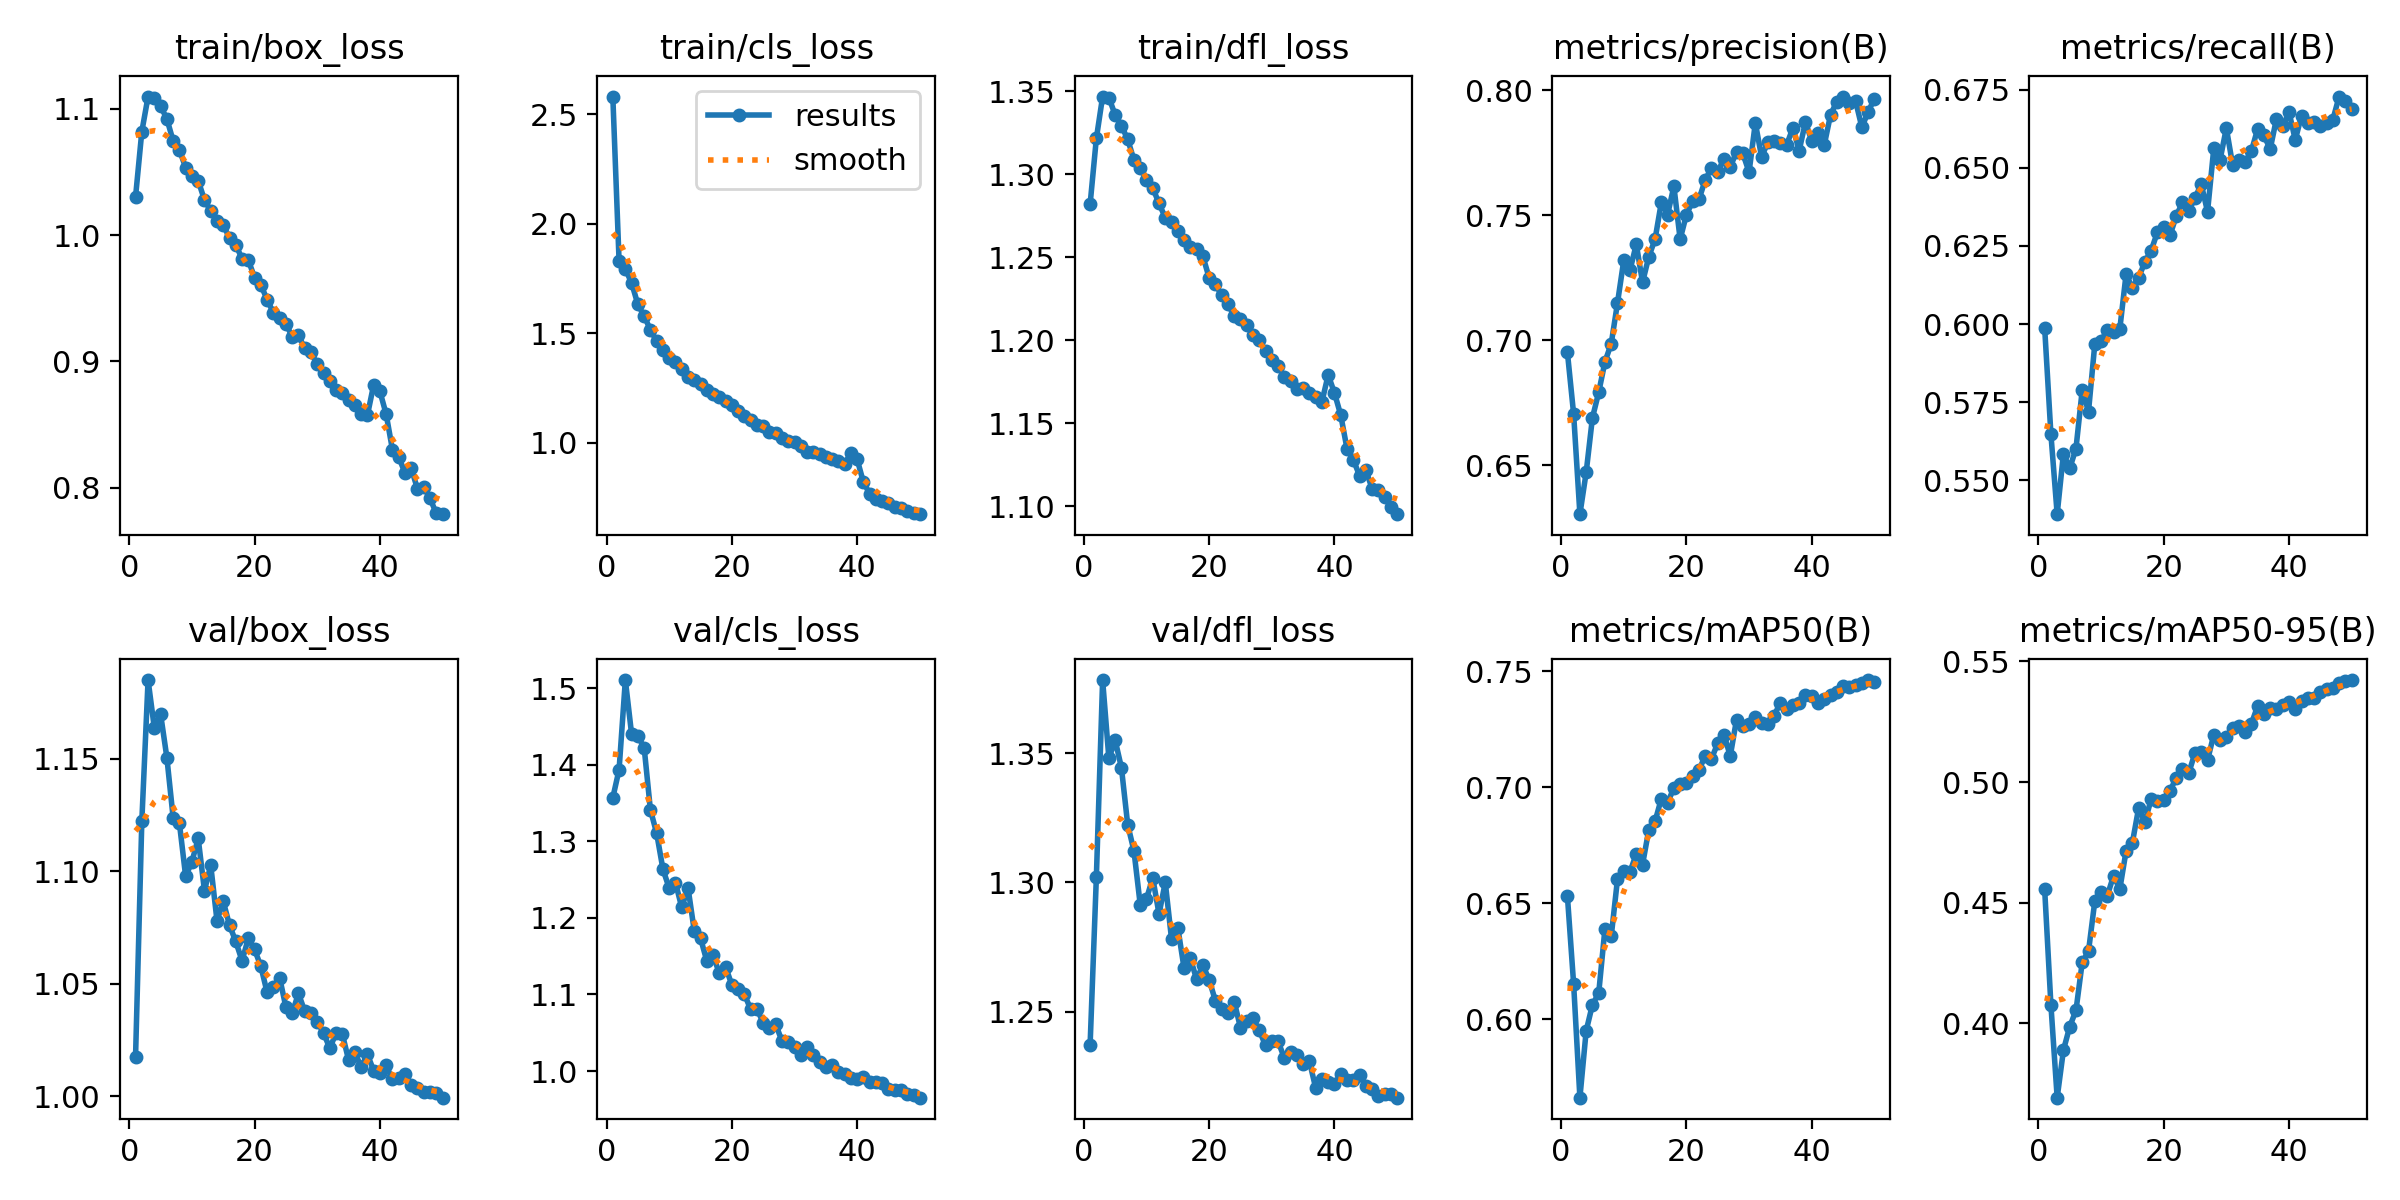

In [2]:
from IPython.display import Image
Image(filename='runs/detect/train1/results.png')


In [3]:
from ultralytics import YOLO
import os

model = YOLO("runs/detect/train1/weights/best.pt")

model.train(
    data=os.path.join(r"C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO", "voc.yaml"),
    epochs=80,
    imgsz=640,
    batch=16,
    device=0,            # GPU
    lr0=0.003,
    cos_lr=True,
    resume=False
)


New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train/weights/best.pt, momentum=0.937, mosaic=1

train: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\train.cache... 8218 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8218/8218 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 192.960.6 MB/s, size: 111.8 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.11G     0.8531     0.9081      1.155         87        640: 100%|██████████| 514/514 [01:22<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


                   all       8333      23605      0.769       0.63      0.704      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80       2.6G     0.9274       1.03      1.199         66        640: 100%|██████████| 514/514 [01:15<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.68it/s]


                   all       8333      23605      0.655      0.519      0.563      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.61G      1.062      1.319      1.297         47        640: 100%|██████████| 514/514 [01:16<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.78it/s]


                   all       8333      23605      0.561      0.426      0.445       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.62G      1.202      1.625      1.398         45        640: 100%|██████████| 514/514 [01:18<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.52it/s]


                   all       8333      23605      0.548      0.369      0.386      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.64G      1.209      1.635      1.407         47        640: 100%|██████████| 514/514 [01:18<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.61it/s]


                   all       8333      23605      0.605      0.483      0.514      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.64G      1.201      1.619      1.401         59        640: 100%|██████████| 514/514 [01:19<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.51it/s]


                   all       8333      23605       0.62      0.482      0.522      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.64G       1.19      1.585      1.396         85        640: 100%|██████████| 514/514 [01:18<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.63it/s]


                   all       8333      23605       0.62       0.48      0.524      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.64G      1.188      1.559      1.388         53        640: 100%|██████████| 514/514 [01:19<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.52it/s]


                   all       8333      23605      0.645      0.489      0.541      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.64G      1.167      1.531      1.379         63        640: 100%|██████████| 514/514 [01:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.61it/s]


                   all       8333      23605      0.647      0.512      0.556      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.64G      1.155      1.503      1.364         61        640: 100%|██████████| 514/514 [01:20<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.52it/s]


                   all       8333      23605      0.664      0.519      0.572      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.64G      1.152      1.488      1.364         69        640: 100%|██████████| 514/514 [01:22<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.40it/s]


                   all       8333      23605      0.648      0.504      0.557      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      2.64G      1.141      1.464      1.358         45        640: 100%|██████████| 514/514 [01:23<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.28it/s]


                   all       8333      23605      0.662      0.515      0.569      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.79G       1.13      1.437      1.348         78        640: 100%|██████████| 514/514 [01:23<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.38it/s]


                   all       8333      23605      0.661      0.521      0.574      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      2.79G      1.121       1.43      1.346         80        640: 100%|██████████| 514/514 [01:24<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.43it/s]


                   all       8333      23605      0.691      0.544      0.604      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.79G      1.113      1.417      1.339         88        640: 100%|██████████| 514/514 [01:24<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.22it/s]


                   all       8333      23605      0.686      0.555      0.613      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.79G      1.106      1.398      1.335         59        640: 100%|██████████| 514/514 [01:24<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.51it/s]


                   all       8333      23605      0.687      0.547      0.615      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.79G      1.102      1.383      1.328         66        640: 100%|██████████| 514/514 [01:22<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.57it/s]


                   all       8333      23605      0.695       0.56      0.619      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.79G      1.091      1.363      1.327         62        640: 100%|██████████| 514/514 [01:24<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.30it/s]


                   all       8333      23605      0.706      0.548      0.619      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.79G       1.09      1.353      1.324         91        640: 100%|██████████| 514/514 [01:23<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:42<00:00,  6.21it/s]


                   all       8333      23605      0.703      0.562      0.622      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      2.79G      1.082      1.338      1.321         64        640: 100%|██████████| 514/514 [01:22<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.24it/s]


                   all       8333      23605      0.694      0.563      0.624       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.79G      1.079      1.318      1.308         35        640: 100%|██████████| 514/514 [01:23<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.51it/s]


                   all       8333      23605      0.718      0.559      0.629      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      3.02G      1.074      1.317      1.307         36        640: 100%|██████████| 514/514 [01:22<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.32it/s]


                   all       8333      23605      0.701      0.563      0.627       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.39G      1.075       1.31      1.307         67        640: 100%|██████████| 514/514 [01:25<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [01:07<00:00,  3.85it/s]


                   all       8333      23605       0.71      0.576      0.641      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.79G      1.063      1.282      1.301         54        640: 100%|██████████| 514/514 [01:32<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:46<00:00,  5.55it/s]


                   all       8333      23605      0.702      0.575      0.643      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.79G      1.044      1.266      1.292         82        640: 100%|██████████| 514/514 [01:36<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:55<00:00,  4.72it/s]


                   all       8333      23605      0.731      0.586       0.66      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      2.79G      1.051      1.259      1.289         78        640: 100%|██████████| 514/514 [01:17<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.61it/s]


                   all       8333      23605      0.726      0.592      0.657      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      2.79G      1.045      1.247      1.286         88        640: 100%|██████████| 514/514 [01:18<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.59it/s]


                   all       8333      23605       0.73      0.583      0.658      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      2.79G      1.036      1.233      1.282         44        640: 100%|██████████| 514/514 [01:18<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.60it/s]


                   all       8333      23605      0.726      0.594      0.659       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80       2.8G      1.022      1.221      1.279         74        640: 100%|██████████| 514/514 [01:19<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.55it/s]


                   all       8333      23605      0.733      0.601      0.672      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80       2.8G       1.03      1.214      1.276         71        640: 100%|██████████| 514/514 [01:18<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.57it/s]


                   all       8333      23605      0.734      0.608      0.673      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       2.8G      1.021      1.192      1.272         49        640: 100%|██████████| 514/514 [01:18<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:40<00:00,  6.43it/s]


                   all       8333      23605      0.727      0.605      0.671      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80       2.8G       1.01      1.175      1.264         79        640: 100%|██████████| 514/514 [01:18<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.82it/s]


                   all       8333      23605       0.74      0.608       0.68      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80       2.8G          1      1.166      1.261         51        640: 100%|██████████| 514/514 [01:17<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.72it/s]


                   all       8333      23605      0.749      0.611      0.686      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80       2.8G     0.9973      1.155      1.253         64        640: 100%|██████████| 514/514 [01:16<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.82it/s]


                   all       8333      23605      0.749      0.616      0.686      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80       2.8G     0.9942      1.141      1.256         79        640: 100%|██████████| 514/514 [01:17<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.82it/s]


                   all       8333      23605      0.754      0.615      0.689      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80       2.8G     0.9896      1.128      1.248         53        640: 100%|██████████| 514/514 [01:16<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:37<00:00,  6.92it/s]


                   all       8333      23605      0.744      0.621       0.69      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80       2.8G     0.9774      1.121      1.242         63        640: 100%|██████████| 514/514 [01:16<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.62it/s]


                   all       8333      23605      0.764      0.616      0.693      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80       2.8G     0.9778      1.111       1.24         55        640: 100%|██████████| 514/514 [01:15<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.70it/s]


                   all       8333      23605      0.761      0.619      0.698      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80       2.8G      0.973      1.094      1.236         49        640: 100%|██████████| 514/514 [01:19<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


                   all       8333      23605      0.763      0.626      0.698      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80       2.8G      0.969      1.101      1.235         87        640: 100%|██████████| 514/514 [01:17<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.78it/s]


                   all       8333      23605      0.751      0.625      0.697      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80       2.8G     0.9572       1.08      1.227         67        640: 100%|██████████| 514/514 [01:18<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.59it/s]


                   all       8333      23605      0.763      0.627      0.702      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80       2.8G     0.9545      1.062      1.225         45        640: 100%|██████████| 514/514 [01:17<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.59it/s]


                   all       8333      23605      0.771       0.62      0.699      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       2.8G     0.9468      1.052      1.221         46        640: 100%|██████████| 514/514 [01:19<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.66it/s]


                   all       8333      23605      0.757       0.64      0.707      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.81G     0.9449      1.042      1.222         51        640: 100%|██████████| 514/514 [01:19<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.74it/s]


                   all       8333      23605       0.76      0.633      0.708      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      2.81G      0.941       1.03      1.214         52        640: 100%|██████████| 514/514 [01:19<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


                   all       8333      23605      0.773      0.633      0.711      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.81G      0.933      1.021      1.213         40        640: 100%|██████████| 514/514 [01:20<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.75it/s]


                   all       8333      23605      0.766      0.635      0.709      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.81G     0.9292      1.005      1.207         46        640: 100%|██████████| 514/514 [01:19<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.65it/s]


                   all       8333      23605      0.774      0.638      0.713      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      2.81G     0.9246      1.003      1.201         50        640: 100%|██████████| 514/514 [01:19<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.68it/s]


                   all       8333      23605      0.784      0.636      0.717      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      2.81G     0.9202      0.983      1.202         60        640: 100%|██████████| 514/514 [01:19<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.69it/s]


                   all       8333      23605      0.779      0.635      0.715       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      2.81G     0.9064     0.9805      1.195         46        640: 100%|██████████| 514/514 [01:18<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.67it/s]


                   all       8333      23605      0.785      0.631      0.717      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      2.81G     0.9071     0.9707      1.191         59        640: 100%|██████████| 514/514 [01:20<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


                   all       8333      23605      0.774      0.643       0.72      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.81G      0.899     0.9574      1.188         46        640: 100%|██████████| 514/514 [01:18<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.63it/s]


                   all       8333      23605      0.783      0.641      0.719      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.81G     0.8956     0.9464      1.183         78        640: 100%|██████████| 514/514 [01:19<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.59it/s]


                   all       8333      23605      0.781      0.645      0.722      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.81G     0.8927     0.9358      1.181         47        640: 100%|██████████| 514/514 [01:18<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:41<00:00,  6.33it/s]


                   all       8333      23605      0.778      0.644      0.723       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.81G     0.8867     0.9406      1.184         50        640: 100%|██████████| 514/514 [01:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


                   all       8333      23605      0.775      0.649      0.722      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.81G     0.8839     0.9296      1.174         74        640: 100%|██████████| 514/514 [01:14<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:37<00:00,  6.98it/s]


                   all       8333      23605      0.777      0.649      0.724      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      2.81G     0.8745     0.9186      1.171         77        640: 100%|██████████| 514/514 [01:13<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 261/261 [00:38<00:00,  6.82it/s]


                   all       8333      23605      0.782      0.641      0.722      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      2.81G     0.8929     0.8993      1.165         73        640:   5%|▌         | 28/514 [00:04<01:13,  6.57it/s]


KeyboardInterrupt: 

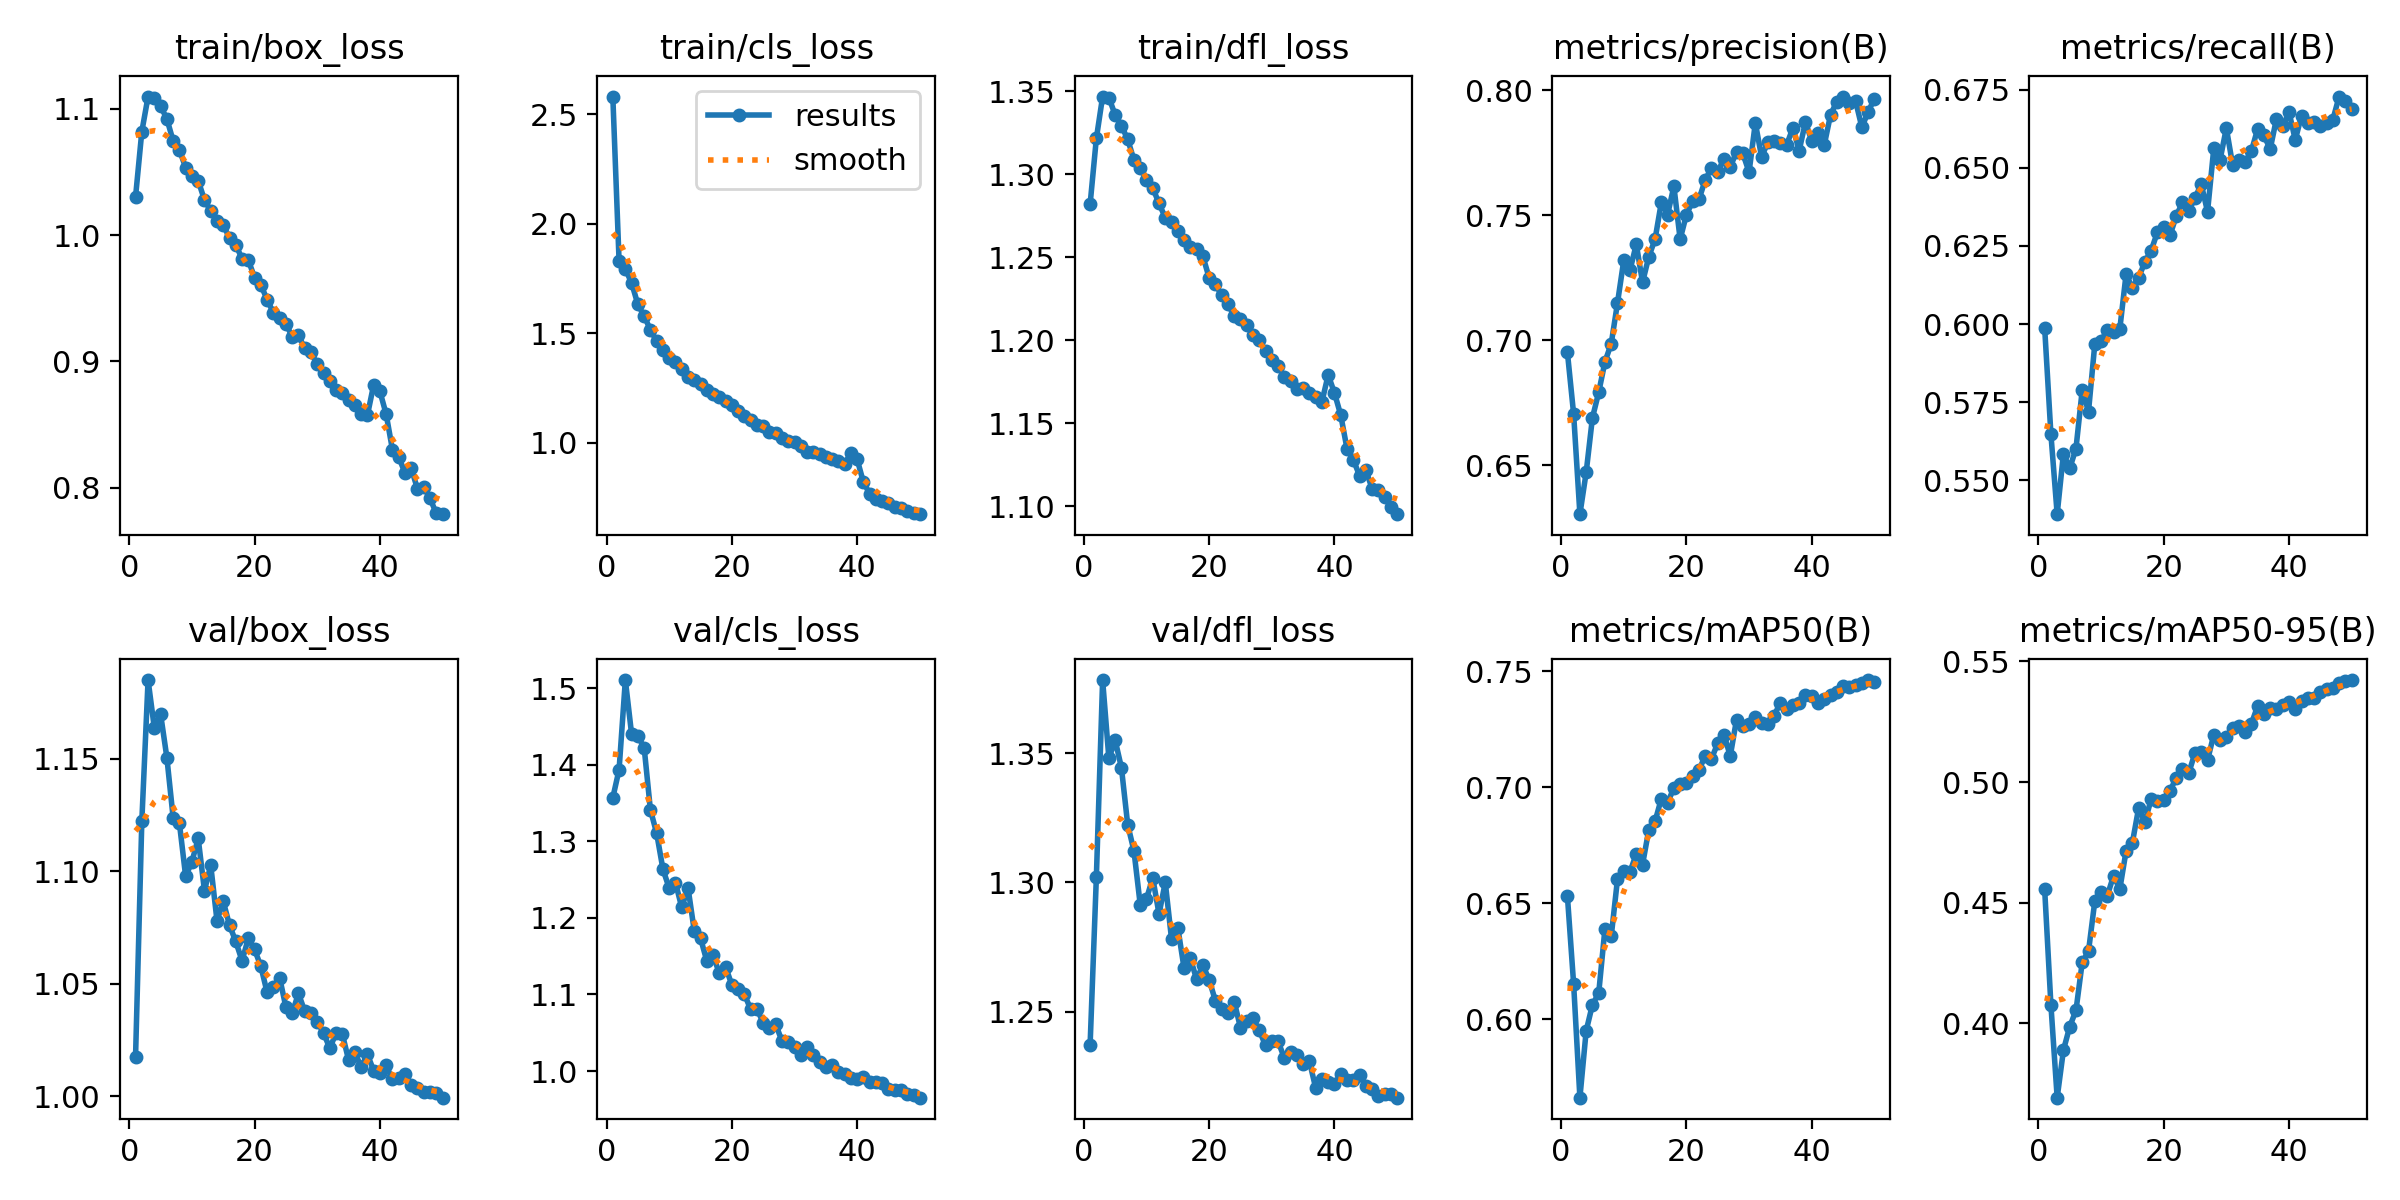

In [6]:
from IPython.display import Image
Image(filename='runs/detect/train1/results.png')


In [9]:
from ultralytics import YOLO

model = YOLO("runs/detect/train1/weights/best.pt")

metrics = model.val()
print(metrics)


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 137.183.6 MB/s, size: 102.1 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [01:08<00:00,  7.60it/s]


                   all       8333      23605      0.797      0.669      0.745      0.542
             aeroplane        475        659      0.863      0.736      0.813      0.614
               bicycle        423        596      0.855       0.71      0.789      0.584
                  bird        525        934      0.832      0.591      0.701      0.484
                  boat        353        681      0.729      0.529      0.621      0.381
                bottle        478       1029      0.804      0.493      0.591      0.396
                   bus        308        461      0.844      0.738       0.81       0.68
                   car        967       1991      0.835      0.699      0.798      0.586
                   cat        722        816      0.837      0.812       0.87      0.679
                 chair        932       2155      0.722      0.501      0.603      0.413
                   cow        229        518      0.762      0.681       0.75      0.542
           diningtabl

In [10]:
from ultralytics import YOLO
import os

model = YOLO("yolov8l.pt")

model.train(
    data=os.path.join(r"C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO", "voc.yaml"),
    epochs=60,
    imgsz=640,
    batch=8,
    device=0,
    patience=10,
    cos_lr=True
)


100%|██████████| 83.7M/83.7M [01:44<00:00, 844kB/s] 


New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, na

train: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\train.cache... 8218 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8218/8218 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 192.846.4 MB/s, size: 111.8 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      5.28G     0.9619      1.587      1.316          5        640: 100%|██████████| 1028/1028 [07:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [03:47<00:00,  2.29it/s]


                   all       8333      23605      0.574      0.509      0.519      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60       5.5G      1.178      1.786      1.494         17        640: 100%|██████████| 1028/1028 [16:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [05:26<00:00,  1.59it/s]


                   all       8333      23605      0.519      0.444      0.427      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      5.37G       1.23      1.907      1.545         42        640: 100%|██████████| 1028/1028 [13:00<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [03:40<00:00,  2.37it/s]


                   all       8333      23605      0.521      0.425      0.429      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      5.25G      1.227      1.865      1.537         14        640: 100%|██████████| 1028/1028 [09:45<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [07:11<00:00,  1.21it/s]


                   all       8333      23605      0.573      0.497      0.511      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      5.37G       1.16      1.721      1.492          9        640: 100%|██████████| 1028/1028 [14:48<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [12:26<00:00,  1.43s/it]


                   all       8333      23605       0.61       0.51      0.539      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      5.37G      1.124       1.63      1.459          8        640: 100%|██████████| 1028/1028 [21:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [12:23<00:00,  1.43s/it]


                   all       8333      23605      0.649      0.531      0.583       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      5.38G      1.104      1.549      1.447          8        640: 100%|██████████| 1028/1028 [19:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [09:18<00:00,  1.07s/it]


                   all       8333      23605      0.649      0.549      0.595      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      5.35G      1.058      1.476       1.43         43        640:   8%|▊         | 84/1028 [01:19<14:55,  1.05it/s]


KeyboardInterrupt: 

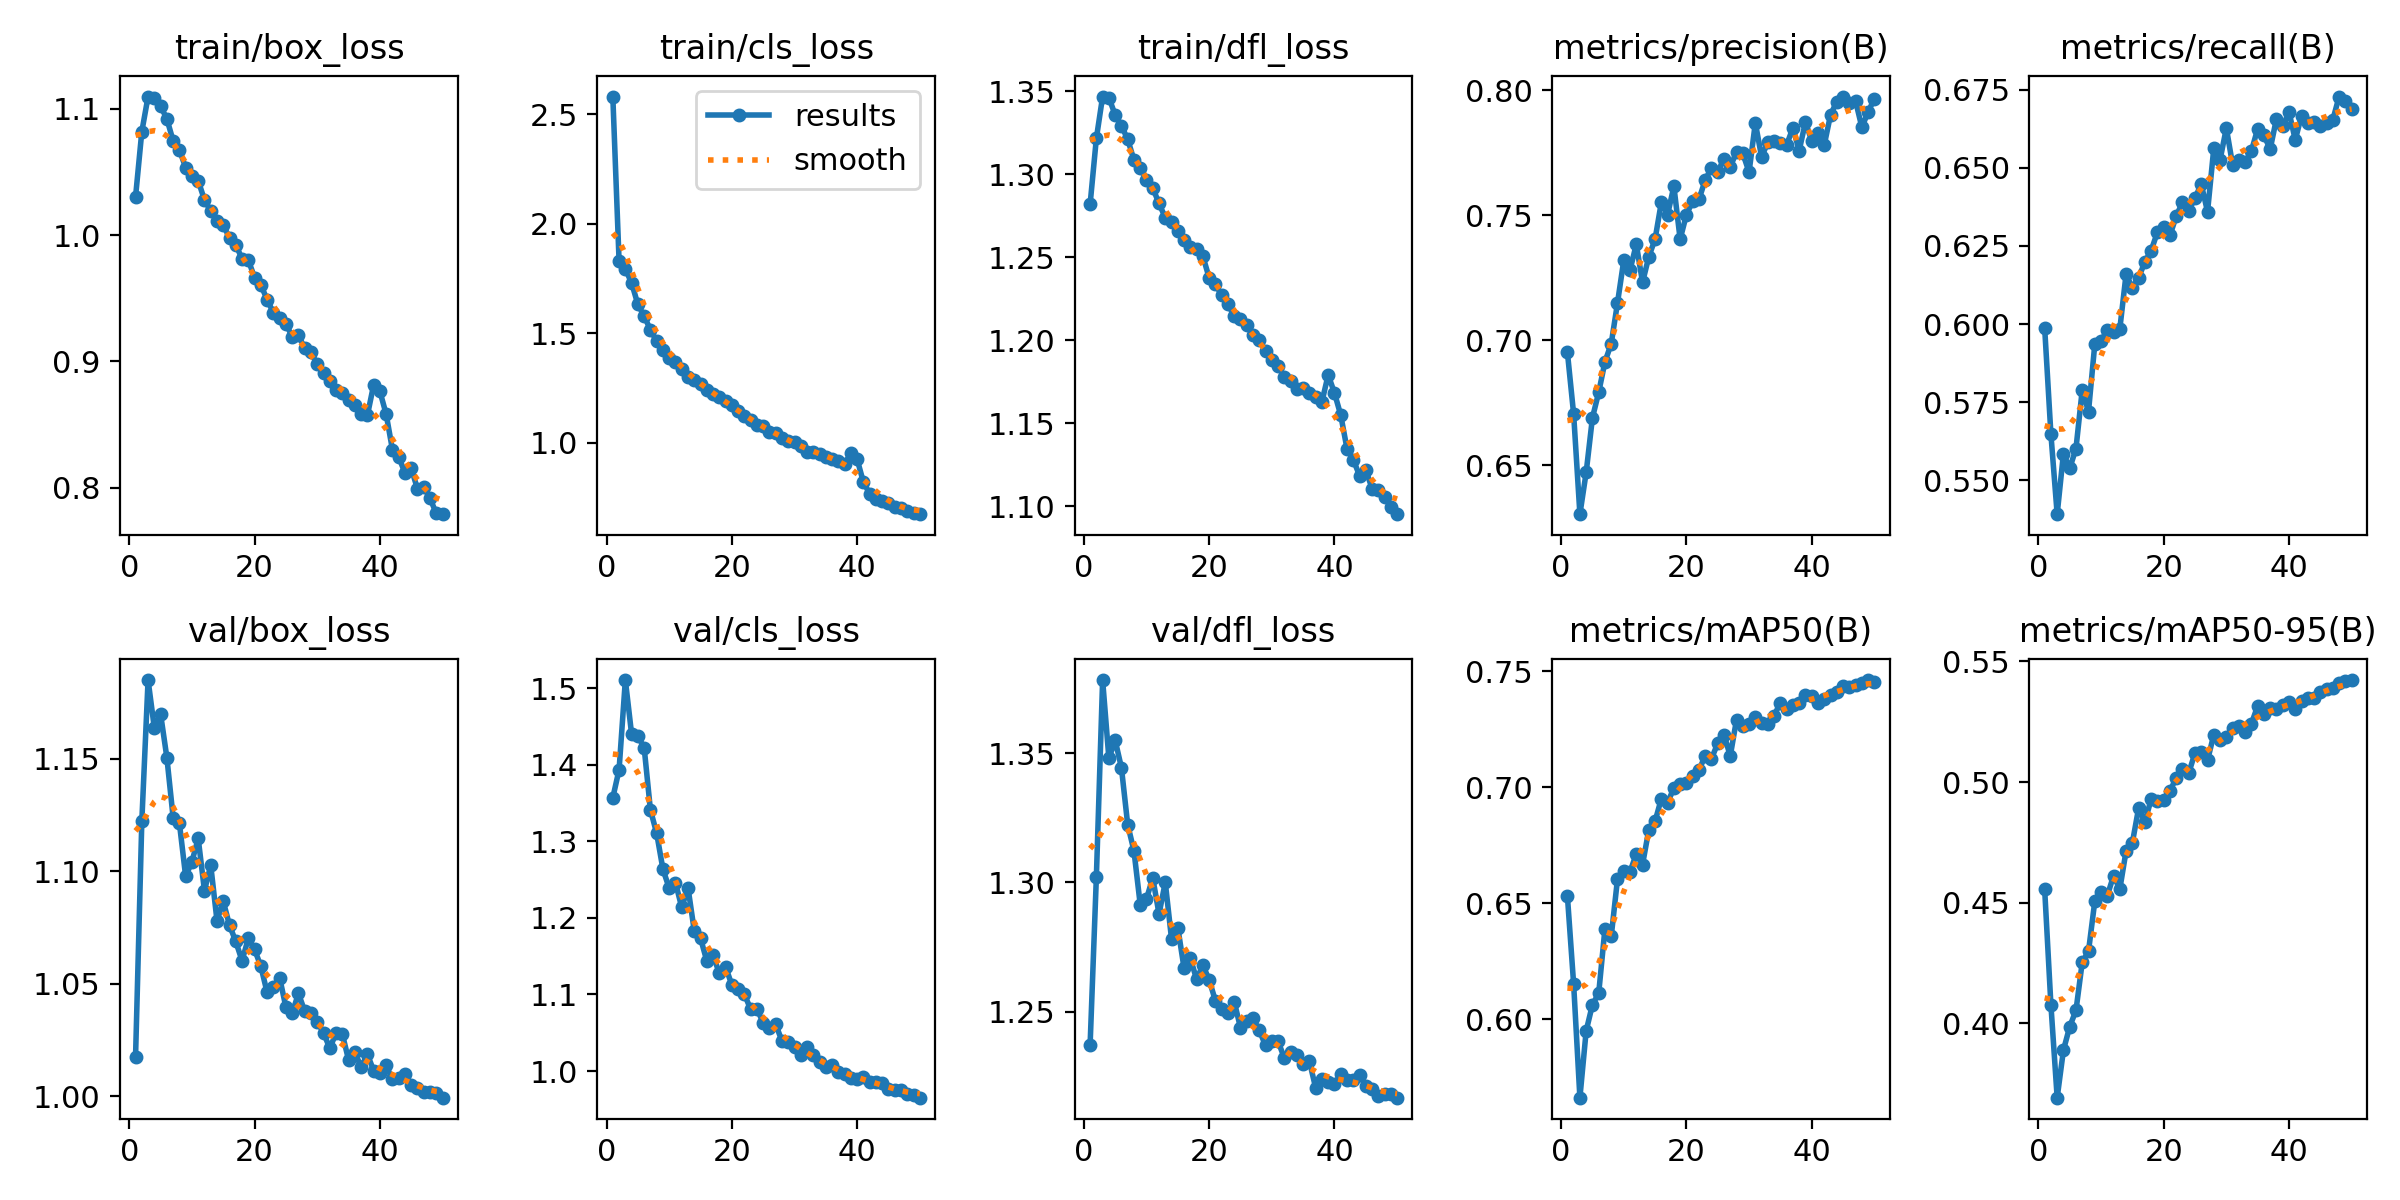

In [1]:
from IPython.display import Image
Image(filename='runs/detect/train1/results.png')


In [2]:
from ultralytics import YOLO

model = YOLO("runs/detect/train1/weights/best.pt")
metrics = model.val()

# Տպել
print("Precision:", metrics.box.precision)
print("Recall:", metrics.box.recall)
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 109.649.3 MB/s, size: 84.1 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [00:45<00:00, 11.33it/s]


                   all       8333      23605      0.797      0.669      0.745      0.542
             aeroplane        475        659      0.863      0.736      0.813      0.614
               bicycle        423        596      0.855       0.71      0.789      0.584
                  bird        525        934      0.832      0.591      0.701      0.484
                  boat        353        681      0.729      0.529      0.621      0.381
                bottle        478       1029      0.804      0.493      0.591      0.396
                   bus        308        461      0.844      0.738       0.81       0.68
                   car        967       1991      0.835      0.699      0.798      0.586
                   cat        722        816      0.837      0.812       0.87      0.679
                 chair        932       2155      0.722      0.501      0.603      0.413
                   cow        229        518      0.762      0.681       0.75      0.542
           diningtabl

AttributeError: 'Metric' object has no attribute 'precision'. See valid attributes below.

    Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

In [4]:
from ultralytics import YOLO

model = YOLO("runs/detect/train1/weights/best.pt")
metrics = model.val()

mp, mr, map50, map95 = metrics.mean_results()

print(f"📊 Precision (mean): {mp:.3f}")
print(f"📊 Recall (mean):    {mr:.3f}")
print(f"📊 mAP@0.5:          {map50:.3f}")
print(f"📊 mAP@0.5:0.95:     {map95:.3f}")
print(f"💪 Fitness Score:   {metrics.fitness:.3f}")


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1127.1675.6 MB/s, size: 114.3 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [00:51<00:00, 10.13it/s]


                   all       8333      23605      0.797      0.669      0.745      0.542
             aeroplane        475        659      0.863      0.736      0.813      0.614
               bicycle        423        596      0.855       0.71      0.789      0.584
                  bird        525        934      0.832      0.591      0.701      0.484
                  boat        353        681      0.729      0.529      0.621      0.381
                bottle        478       1029      0.804      0.493      0.591      0.396
                   bus        308        461      0.844      0.738       0.81       0.68
                   car        967       1991      0.835      0.699      0.798      0.586
                   cat        722        816      0.837      0.812       0.87      0.679
                 chair        932       2155      0.722      0.501      0.603      0.413
                   cow        229        518      0.762      0.681       0.75      0.542
           diningtabl

In [5]:
from ultralytics import YOLO

model = YOLO("runs/detect/train1/weights/best.pt")

metrics = model.val(save=True, save_json=True)


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1096.3412.9 MB/s, size: 97.7 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [00:49<00:00, 10.59it/s]


                   all       8333      23605      0.797      0.669      0.745      0.542
             aeroplane        475        659      0.863      0.736      0.813      0.614
               bicycle        423        596      0.855       0.71      0.789      0.584
                  bird        525        934      0.832      0.591      0.701      0.484
                  boat        353        681      0.729      0.529      0.621      0.381
                bottle        478       1029      0.804      0.493      0.591      0.396
                   bus        308        461      0.844      0.738       0.81       0.68
                   car        967       1991      0.835      0.699      0.798      0.586
                   cat        722        816      0.837      0.812       0.87      0.679
                 chair        932       2155      0.722      0.501      0.603      0.413
                   cow        229        518      0.762      0.681       0.75      0.542
           diningtabl

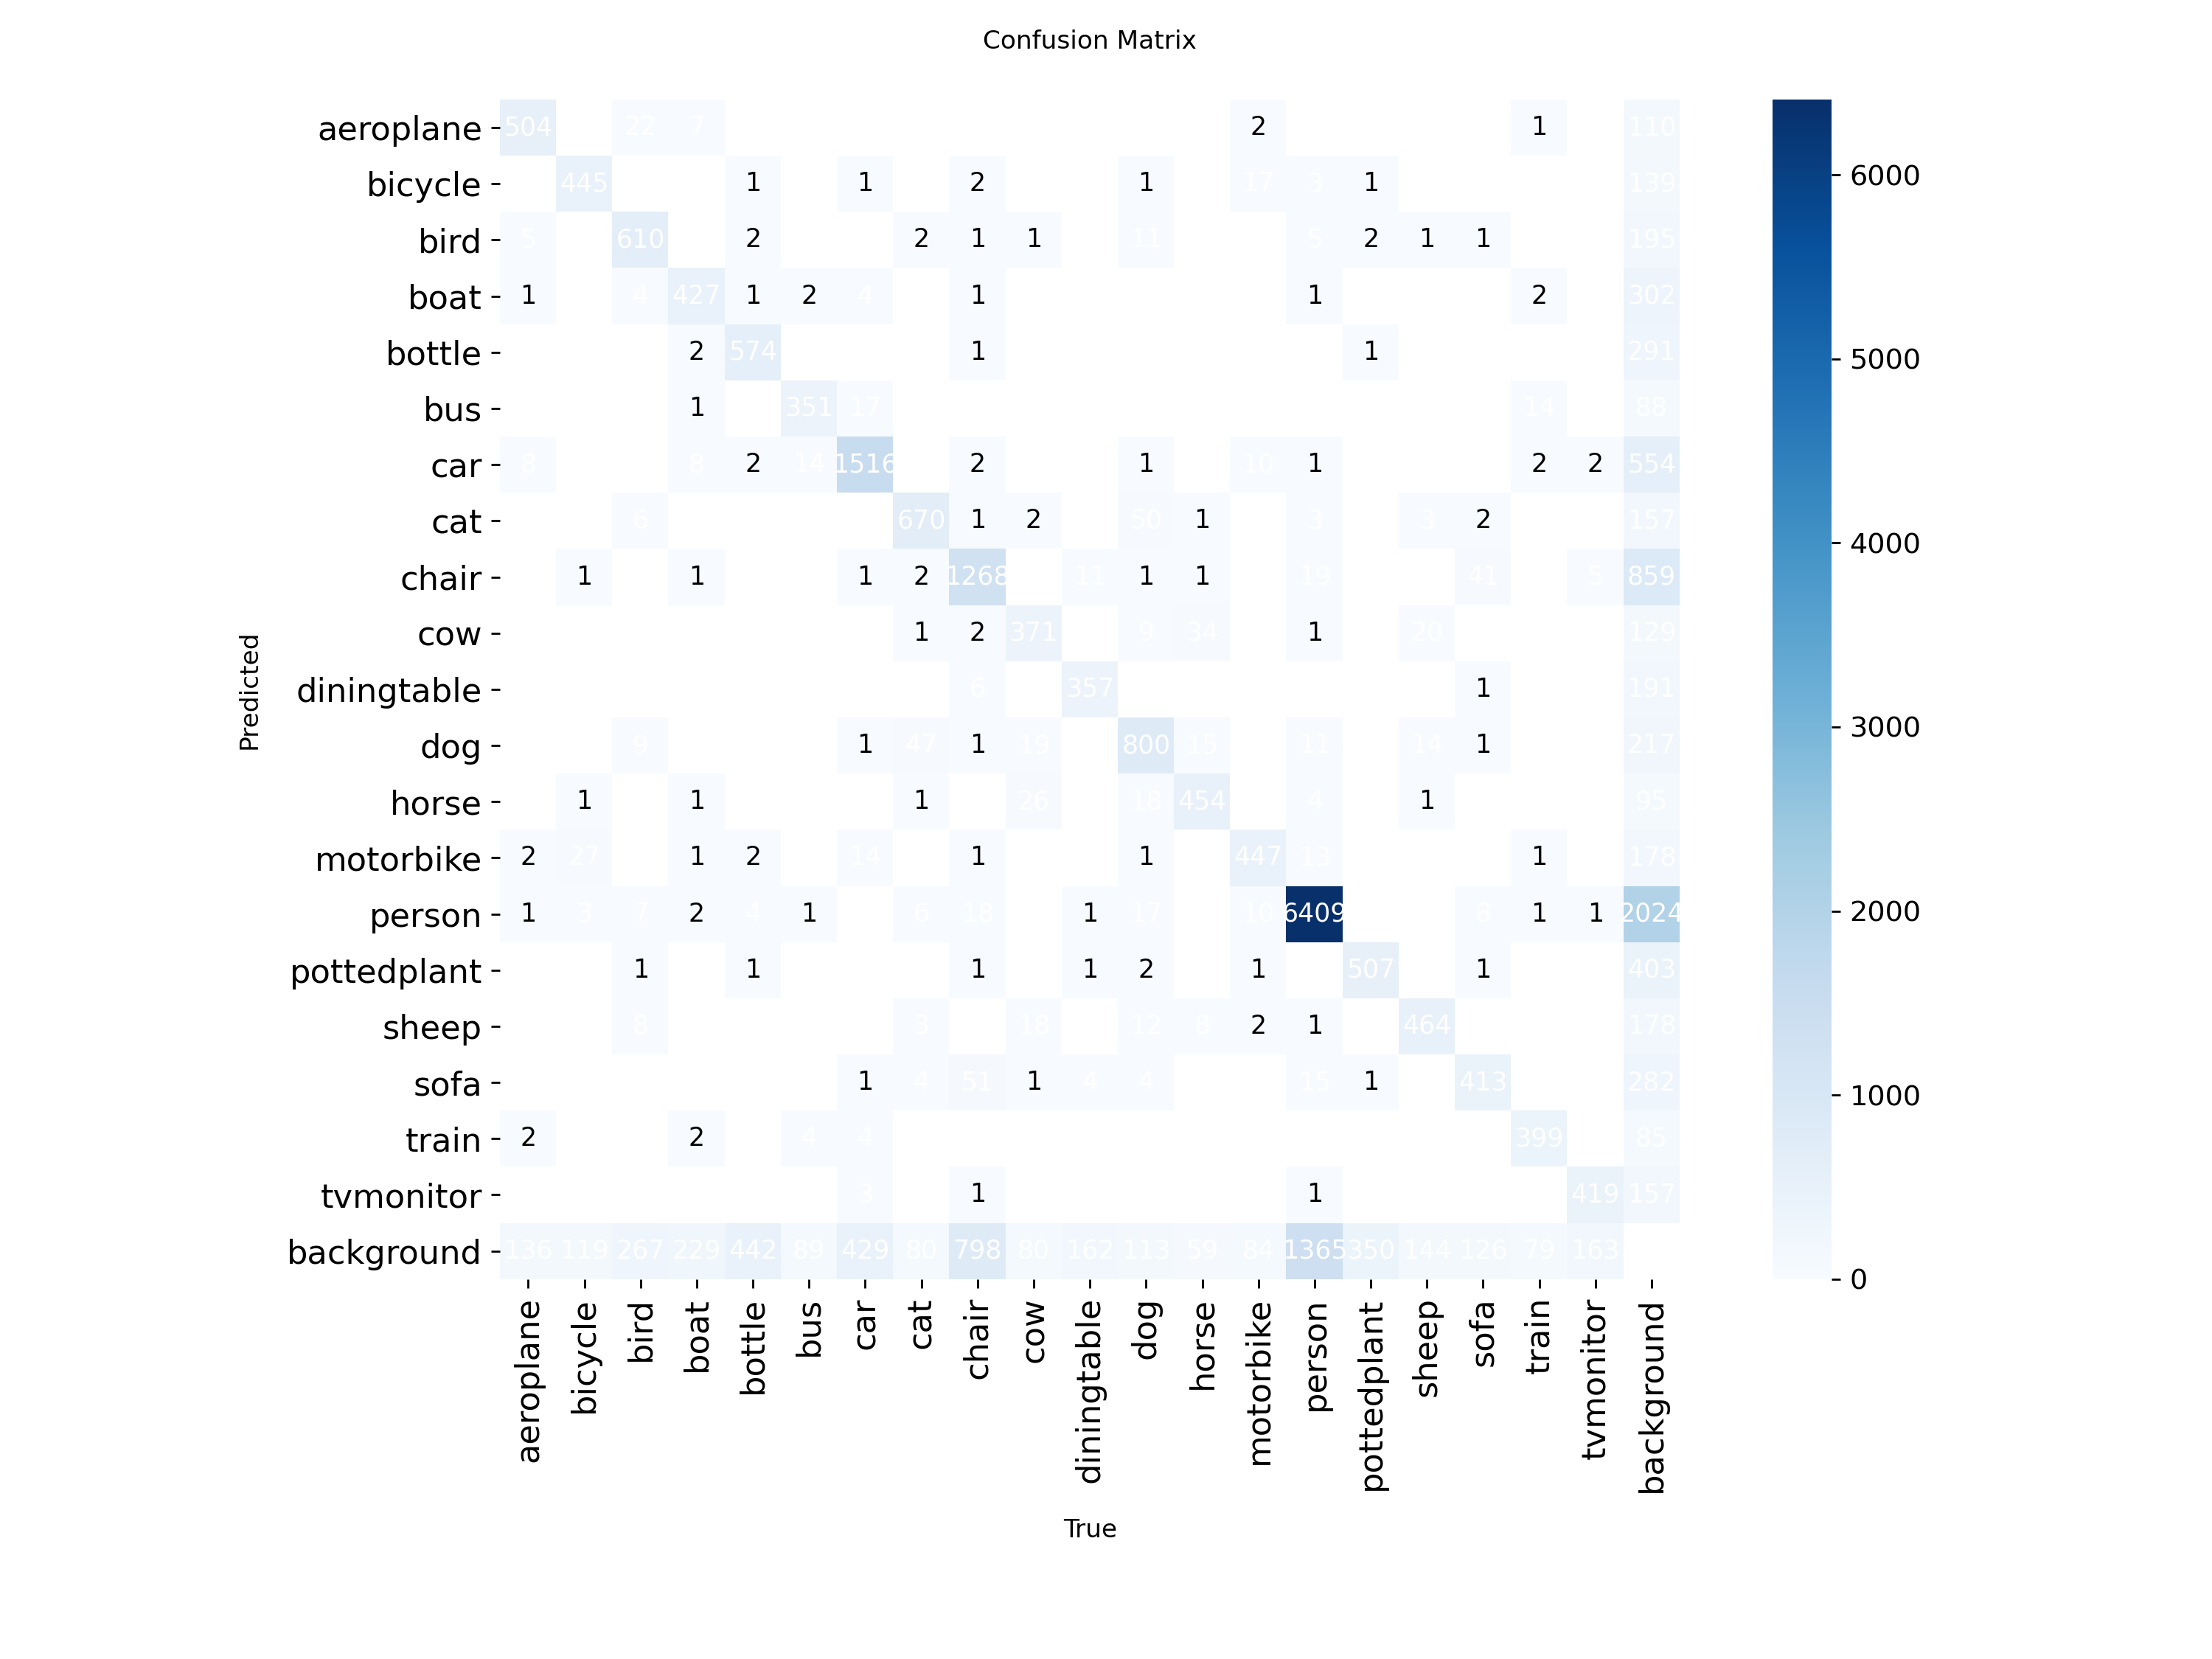

In [6]:
from IPython.display import Image
Image(filename='runs/detect/val5/confusion_matrix.png')


In [12]:
print("Precision:", metrics.box.p.mean())
print("Recall:", metrics.box.r.mean())
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)


Precision: 0.796829646013052
Recall: 0.6685665517249718
mAP@0.5: 0.7451507938468157
mAP@0.5:0.95: 0.5421062642531581


In [2]:
from ultralytics import YOLO

model = YOLO("runs/detect/train10/weights/last.pt")

model.train(
    resume=True,
    epochs=60,
    patience=10,
    device=0
)


New https://pypi.org/project/ultralytics/8.3.144 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\train10\weights\last.pt, momentum=0.937, mosaic=1

train: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\train.cache... 8218 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8218/8218 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.664.8 MB/s, size: 111.8 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Resuming training runs\detect\train10\weights\last.pt from epoch 8 to 60 total epochs
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      5.14G      1.055      1.475      1.414          5        640: 100%|██████████| 1028/1028 [07:31<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [03:52<00:00,  2.24it/s]


                   all       8333      23605      0.667      0.586      0.635      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      5.35G      1.025      1.388      1.392         17        640: 100%|██████████| 1028/1028 [14:46<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [13:28<00:00,  1.55s/it]


                   all       8333      23605      0.698      0.553      0.619       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      5.32G      1.001      1.337      1.374         42        640: 100%|██████████| 1028/1028 [16:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [06:22<00:00,  1.36it/s]


                   all       8333      23605      0.692      0.591      0.647      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      5.36G     0.9978      1.294      1.364         14        640: 100%|██████████| 1028/1028 [11:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [17:25<00:00,  2.01s/it]


                   all       8333      23605       0.72      0.599      0.665      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      5.31G     0.9653      1.225      1.337          9        640: 100%|██████████| 1028/1028 [12:07<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [05:53<00:00,  1.48it/s]


                   all       8333      23605      0.715      0.612      0.682      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      5.34G     0.9433      1.185      1.322          8        640: 100%|██████████| 1028/1028 [09:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [11:49<00:00,  1.36s/it]


                   all       8333      23605      0.753      0.621      0.699      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      5.31G     0.9375      1.148      1.315          8        640: 100%|██████████| 1028/1028 [17:24<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [06:59<00:00,  1.24it/s]


                   all       8333      23605      0.741      0.635      0.703      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      5.34G      0.938      1.153      1.324         11        640: 100%|██████████| 1028/1028 [08:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [14:47<00:00,  1.70s/it]


                   all       8333      23605      0.746      0.632      0.706      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      5.32G     0.9336      1.143       1.32         17        640: 100%|██████████| 1028/1028 [10:55<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [12:09<00:00,  1.40s/it]


                   all       8333      23605      0.761      0.643      0.722       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      5.34G     0.9233      1.101      1.308          8        640: 100%|██████████| 1028/1028 [15:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [18:35<00:00,  2.14s/it]


                   all       8333      23605      0.759      0.642      0.721      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      5.35G     0.9112       1.07      1.295         20        640: 100%|██████████| 1028/1028 [12:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [07:44<00:00,  1.12it/s]


                   all       8333      23605      0.758      0.653      0.727      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      5.36G     0.8985      1.047      1.288         18        640: 100%|██████████| 1028/1028 [12:27<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [13:55<00:00,  1.60s/it]


                   all       8333      23605      0.768      0.665      0.734       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      5.31G     0.8853      1.014      1.275         19        640: 100%|██████████| 1028/1028 [13:46<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [05:59<00:00,  1.45it/s]


                   all       8333      23605      0.774       0.66      0.736      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      5.32G     0.8748     0.9909      1.269         15        640: 100%|██████████| 1028/1028 [11:26<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [15:23<00:00,  1.77s/it]


                   all       8333      23605      0.783      0.663      0.743      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      5.28G      0.847     0.9548      1.255         53        640:  46%|████▋     | 476/1028 [07:13<08:22,  1.10it/s]


KeyboardInterrupt: 

In [3]:
from ultralytics import YOLO

model = YOLO("runs/detect/train10/weights/best.pt")
metrics = model.val()

mp, mr, map50, map95 = metrics.mean_results()
print(f"📊 Precision (mean): {mp:.3f}")
print(f"📊 Recall (mean):    {mr:.3f}")
print(f"📊 mAP@0.5:          {map50:.3f}")
print(f"📊 mAP@0.5:0.95:     {map95:.3f}")
print(f"💪 Fitness Score:   {metrics.fitness:.3f}")


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 112 layers, 43,622,028 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 205.0118.6 MB/s, size: 108.4 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [03:33<00:00,  2.44it/s]


                   all       8333      23605      0.782      0.664      0.743      0.552
             aeroplane        475        659      0.811      0.747      0.804      0.624
               bicycle        423        596      0.845      0.666      0.787      0.587
                  bird        525        934      0.797      0.619        0.7      0.505
                  boat        353        681      0.645      0.521      0.591      0.369
                bottle        478       1029      0.766      0.553      0.619      0.429
                   bus        308        461      0.837      0.759      0.807      0.691
                   car        967       1991      0.803      0.752      0.814      0.598
                   cat        722        816      0.871       0.76      0.871      0.695
                 chair        932       2155      0.729      0.462      0.588      0.404
                   cow        229        518       0.74      0.643      0.714       0.54
           diningtabl

In [1]:
from ultralytics import YOLO

model = YOLO("runs/detect/train10/weights/best.pt")

metrics = model.val(save=True)


Ultralytics 8.3.141  Python-3.11.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 112 layers, 43,622,028 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 162.579.2 MB/s, size: 106.7 KB)


val: Scanning C:\Users\lilit\Kaggle-projects\yolo_voc_project\VOC_YOLO\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8333/8333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 521/521 [04:28<00:00,  1.94it/s]


                   all       8333      23605      0.782      0.664      0.743      0.552
             aeroplane        475        659      0.811      0.747      0.804      0.624
               bicycle        423        596      0.845      0.666      0.787      0.587
                  bird        525        934      0.797      0.619        0.7      0.505
                  boat        353        681      0.645      0.521      0.591      0.369
                bottle        478       1029      0.766      0.553      0.619      0.429
                   bus        308        461      0.837      0.759      0.807      0.691
                   car        967       1991      0.803      0.752      0.814      0.598
                   cat        722        816      0.871       0.76      0.871      0.695
                 chair        932       2155      0.729      0.462      0.588      0.404
                   cow        229        518       0.74      0.643      0.714       0.54
           diningtabl

In [5]:
import os
import pandas as pd

base_path = "runs/detect"
best_score = -1
best_folder = None

results_summary = []

for i in range(1, 11):
    folder = f"train{i}"
    csv_path = os.path.join(base_path, folder, "results.csv")

    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        last_row = df.iloc[-1]
        precision = last_row["metrics/precision(B)"]
        recall = last_row["metrics/recall(B)"]
        map50 = last_row["metrics/mAP50(B)"]
        map95 = last_row["metrics/mAP50-95(B)"]

        results_summary.append({
            "folder": folder,
            "precision": precision,
            "recall": recall,
            "mAP50": map50,
            "mAP50-95": map95
        })

        if map95 > best_score:
            best_score = map95
            best_folder = folder

results_df = pd.DataFrame(results_summary)
print("📊 Summary of all runs:")
print(results_df)

print(f"\n✅ Best model based on mAP50-95 is in: {best_folder}")


📊 Summary of all runs:
    folder  precision   recall    mAP50  mAP50-95
0   train1    0.79667  0.66872  0.74519   0.54230
1   train2    0.78195  0.64148  0.72200   0.51936
2  train10    0.78298  0.66307  0.74296   0.55154

✅ Best model based on mAP50-95 is in: train10


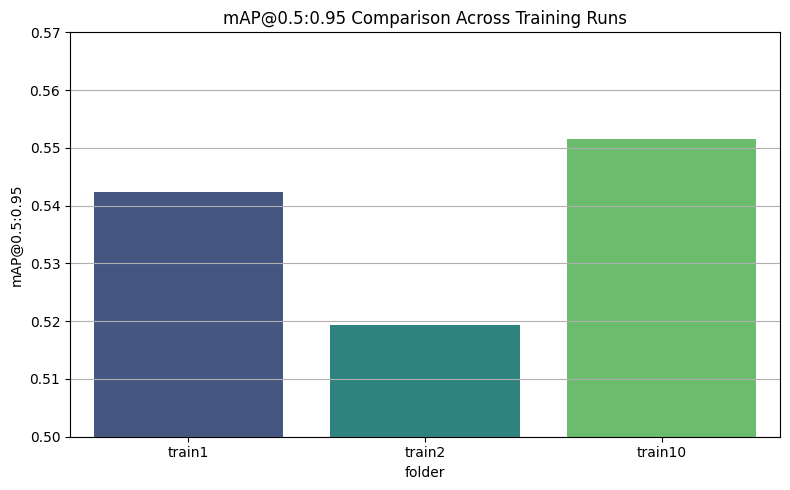

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    "folder": ["train1", "train2", "train10"],
    "mAP50_95": [0.54230, 0.51936, 0.55154]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="folder", y="mAP50_95", hue="folder", dodge=False, palette="viridis", legend=False)
plt.title("mAP@0.5:0.95 Comparison Across Training Runs")
plt.ylabel("mAP@0.5:0.95")
plt.ylim(0.5, 0.57)
plt.grid(True, axis='y')
plt.tight_layout()

plt.show(block=True)


C:\Users\lilit\AppData\Local\Temp\ipykernel_11504\3465727480.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\lilit\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


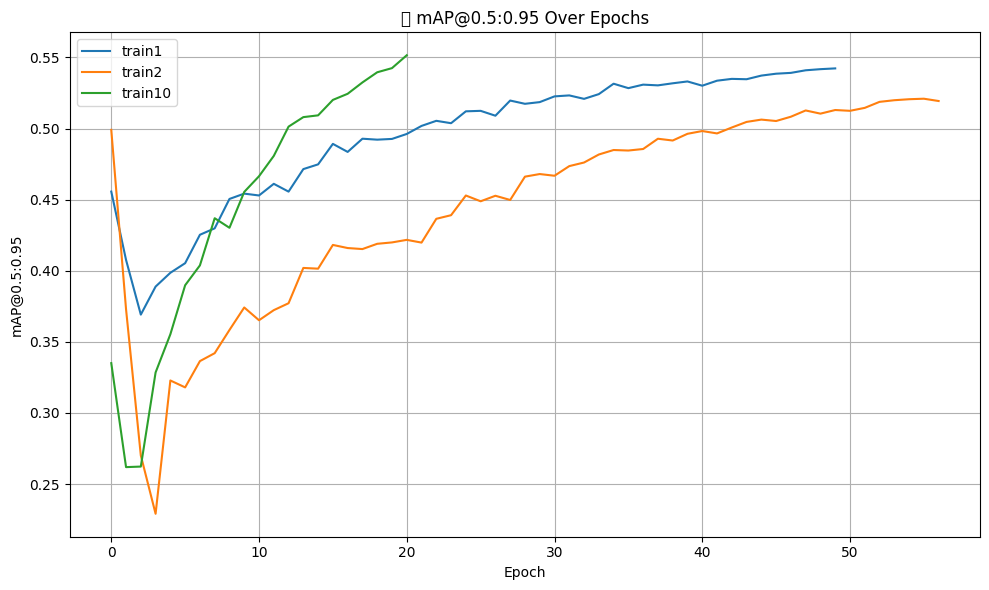

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

folders = ["train1", "train2", "train10"]
base_path = "runs/detect"

plt.figure(figsize=(10, 6))

for folder in folders:
    try:
        df = pd.read_csv(f"{base_path}/{folder}/results.csv")
        plt.plot(df.index, df["metrics/mAP50-95(B)"], label=folder)
    except Exception as e:
        print(f"❌ Failed for {folder}: {e}")

plt.title("📈 mAP@0.5:0.95 Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5:0.95")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


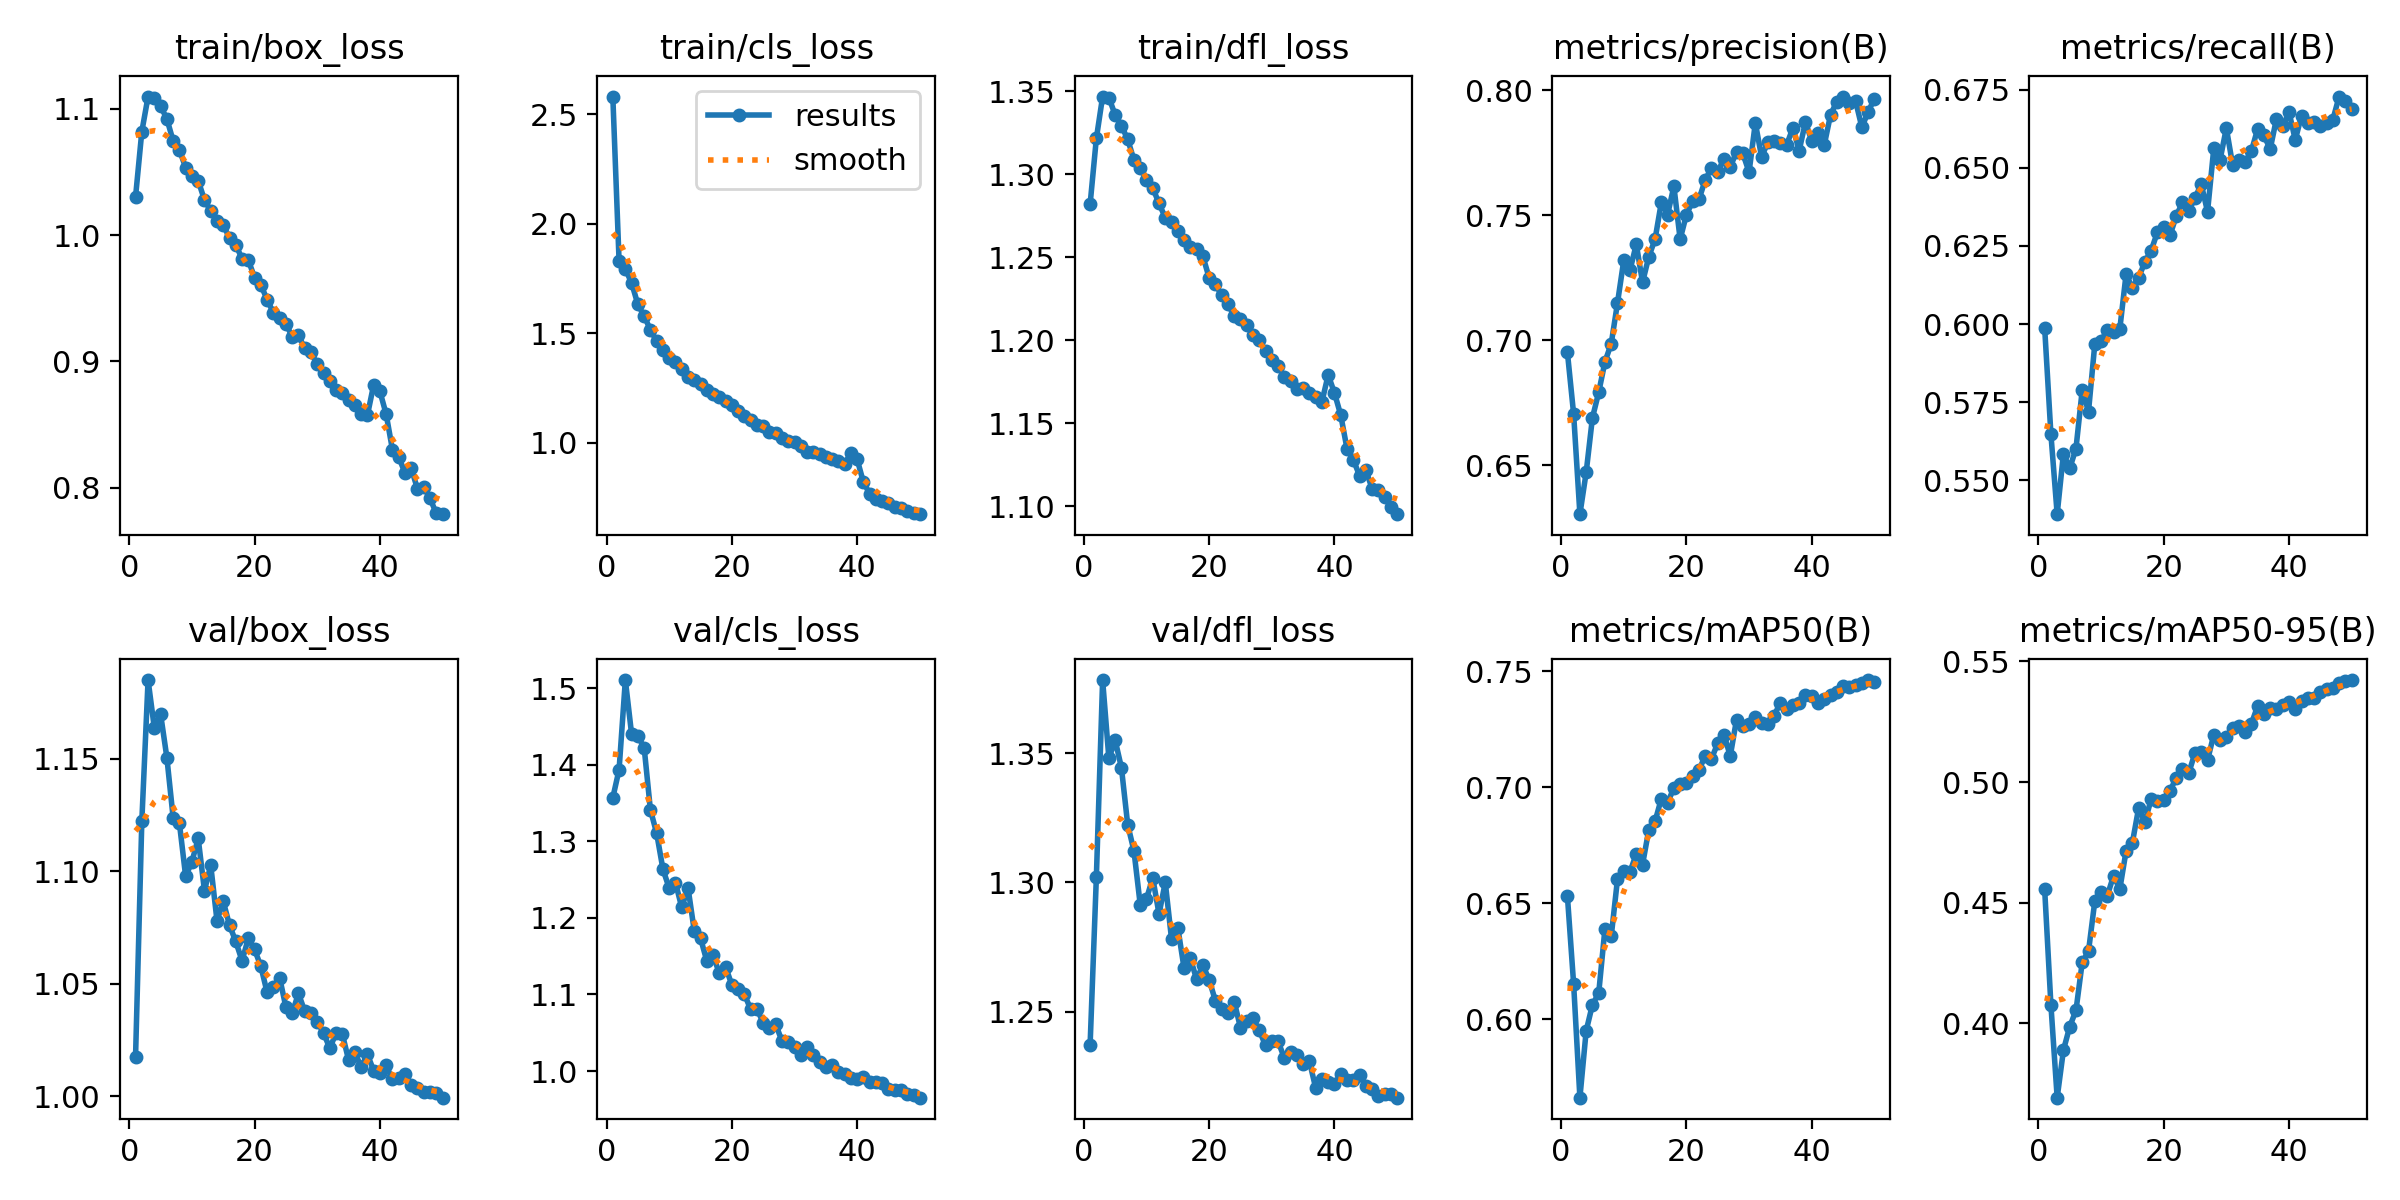

In [18]:
from IPython.display import Image
Image(filename='runs/detect/train1/results.png')

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO('runs/detect/train10/weights/best.pt')
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    results = model(frame)
    frame = results[0].plot()
    cv2.imshow("YOLOv8 Prediction", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break
    results = model(frame)
    frame = results[0].plot()
    cv2.imshow("YOLOv8 Prediction", frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()




0: 480x640 1 bottle, 1 person, 44.9ms
Speed: 1.6ms preprocess, 44.9ms inference, 80.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 2 persons, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 2 persons, 29.2ms
Speed: 1.2ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 2 persons, 28.1ms
Speed: 0.9ms preprocess, 28.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 chair, 2 persons, 24.6ms
Speed: 0.9ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 chair, 2 persons, 22.7ms
Speed: 1.1ms preprocess, 22.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 2 persons, 22.7ms
Speed: 1.0ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 2